In [ ]:
# ==============================================================================
# BAGIAN 0A: INSTALASI DEPENDENSI SISTEM (NODE.JS)
# ==============================================================================
print("🚀 Tahap 0A: Menginstal Node.js...")
!sudo apt-get update > /dev/null
!sudo apt-get install -y ca-certificates curl gnupg > /dev/null
!sudo mkdir -p /etc/apt/keyrings
!curl -fsSL https://deb.nodesource.com/gpgkey/nodesource-repo.gpg.key | sudo gpg --dearmor -o /etc/apt/keyrings/nodesource.gpg > /dev/null
!NODE_MAJOR=20 && echo "deb [signed-by=/etc/apt/keyrings/nodesource.gpg] https://deb.nodesource.com/node_$NODE_MAJOR.x nodistro main" | sudo tee /etc/apt/sources.list.d/nodesource.list > /dev/null
!sudo apt-get update > /dev/null
!sudo apt-get install nodejs -y > /dev/null
print("✅ Node.js berhasil diinstal.")
!node -v

# ==============================================================================
# BAGIAN 0B: INSTALASI LIBRARY PYTHON
# ==============================================================================
print("\n🚀 Tahap 0B: Menginstal library Python...")
!pip install pandas transformers torch nltk scikit-learn seaborn matplotlib wordcloud -q

# Import library utama
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import collections
from wordcloud import WordCloud
from transformers import pipeline

# Import untuk Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

print("✅ Library Python berhasil diinstal dan di-import.")

# Mengunduh resource NLTK (stopwords & tokenizer)
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords', quiet=True)
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt', quiet=True)

🚀 Tahap 0A: Menginstal Node.js...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
E: dpkg was interrupted, you must manually run 'sudo dpkg --configure -a' to correct the problem. 
gpg: cannot open '/dev/tty': No such device or address
curl: (23) Failed writing body
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
E: dpkg was interrupted, you must manually run 'sudo dpkg --configure -a' to correct the problem. 
✅ Node.js berhasil diinstal.
v20.19.0

🚀 Tahap 0B: Menginstal library Python...
✅ Library Python berhasil diinstal dan di-import.


In [ ]:
# ==============================================================================
# BAGIAN 1: OTENTIKASI & PENGAMBILAN DATA (CRAWLING)
# ==============================================================================
twitter_auth_token = '9562152d50105942e54c76704ae9aa5456608eb5'

filename = 'Iran_Israel_BTC.csv'
# Menggunakan query yang lebih fokus pada sentimen investasi
search_keyword = '(BTC OR Bitcoin) AND ("konflik Iran Israel" OR "perang Iran Israel") since:2024-11-01 until:2025-07-12 lang:id'
limit = 2000 # Jumlah tweet yang akan diambil

print(f"\n⛏️ Memulai proses crawling data dari Twitter...")

# Menjalankan perintah crawling menggunakan NPX (untuk paket Node.js)
!npx -y tweet-harvest@2.6.1 -o "{filename}" -s "{search_keyword}" --tab "LATEST" -l {limit} --token {twitter_auth_token}

print("✅ Proses crawling selesai.")


⛏️ Memulai proses crawling data dari Twitter...
⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋Tweet Harvest [v2.6.1]

Research by Helmi Satria
Use it for Educational Purposes only!

This script uses Chromium Browser to crawl data from Twitter with your Twitter auth token.
Please enter your Twitter auth token when prompted.

Note: Keep your access token secret! Don't share it with anyone else.
Note: This script only runs on your local device.


Opening twitter search page...


Filling in keywords: (BTC OR Bitcoin) AND (konflik


-- Scrolling... (1) (2)

Your tweets saved to: /content/tweets-data/Iran_Israel_BTC.csv
Total tweets saved: 20

-- Scrolling... (1)

Your tweets saved to: /content/tweets-data/Iran_Israel_BTC.csv
Total tweets saved: 39

-- Scrolling... (1) (2) (3) (4)

Your tweets saved to: /content/tweets-data/Iran_Israel_BTC.csv
Total tweets saved: 58

-- Scrolling... (1)

Your tweets saved to: /content/tweets-data/Iran_Israel_BTC.csv
Total tweets saved: 77

-- Scrolling... (1)

Your tweets saved to: /content/t

In [ ]:
# ==============================================================================
# BAGIAN 2: PEMUATAN & PRA-PEMROSESAN DATA
# ==============================================================================
import nltk
nltk.download('punkt_tab')
# Memuat data hasil crawling
file_path = f"tweets-data/{filename}"
try:
    df = pd.read_csv(file_path, delimiter=",")
    print(f"\n🔄 Data berhasil dimuat. Ditemukan {len(df)} tweets.")
except FileNotFoundError:
    print(f"❌ Error: File {file_path} tidak ditemukan. Pastikan proses crawling berhasil.")
    # Membuat DataFrame kosong untuk mencegah error lanjutan jika crawling gagal
    df = pd.DataFrame(columns=['full_text'])


# Fungsi untuk membersihkan teks (untuk BERT dan Word Cloud)
def clean_text(text):
    text = str(text)
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE) # Hapus URL
    text = re.sub(r'\@\w+', '', text) # Hapus mention
    text = re.sub(r'#', '', text) # Hanya hapus simbol #, biarkan katanya
    text = text.lower() # Ubah menjadi huruf kecil
    return text.strip()

# Fungsi untuk memproses teks lebih lanjut (untuk TF-IDF)
stop_words_indonesian = set(nltk.corpus.stopwords.words('indonesian'))
def process_text_for_tfidf(text):
    text = clean_text(text)
    text = re.sub(r'[^a-zA-Z\s]', '', text) # Hapus angka dan tanda baca
    tokens = nltk.word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words_indonesian and len(word) > 2]
    return " ".join(filtered_tokens)

if not df.empty:
    # Menerapkan fungsi pembersihan
    df.dropna(subset=['full_text'], inplace=True)
    df['cleaned_text'] = df['full_text'].apply(clean_text)
    df['processed_text'] = df['full_text'].apply(process_text_for_tfidf)
    print("✅ Pra-pemrosesan teks selesai.")


🔄 Data berhasil dimuat. Ditemukan 326 tweets.
✅ Pra-pemrosesan teks selesai.


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# ==============================================================================
# BAGIAN 3: PELABELAN SENTIMEN DENGAN BERT (GROUND TRUTH)
# ==============================================================================
if not df.empty:
    print("\n🤖 Memuat model AI (BERT) untuk analisis sentimen Bahasa Indonesia...")
    sentiment_analyzer = pipeline(
        'sentiment-analysis',
        model='mdhugol/indonesia-bert-sentiment-classification'
    )
    print("✅ Model AI berhasil dimuat.")

    def get_sentiment(text):
        if not isinstance(text, str) or not text.strip():
            return "Neutral" # Beri label Netral jika teks kosong
        try:
            # Mengambil label dari hasil analisis (e.g., 'positive', 'negative', 'neutral')
            result = sentiment_analyzer(text)
            return result[0]['label'].capitalize()
        except Exception as e:
            return "Neutral" # Jika ada error saat analisis

    print("⏳ Menerapkan analisis sentimen pada data... Ini mungkin memakan waktu.")
    # Menggunakan 'cleaned_text' untuk mendapatkan hasil sentimen yang lebih baik
    df['sentiment'] = df['cleaned_text'].apply(get_sentiment)

    label_map = {
        'Label_0': 'Negative',
        'Label_1': 'Neutral',
        'Label_2': 'Positive'
    }
    df['sentiment'] = df['sentiment'].map(label_map).fillna('Neutral') # .fillna untuk menangani jika ada label tak terduga

    print("✅ Pelabelan sentimen dengan BERT dan pemetaan label selesai.")


🤖 Memuat model AI (BERT) untuk analisis sentimen Bahasa Indonesia...


Device set to use cpu


✅ Model AI berhasil dimuat.
⏳ Menerapkan analisis sentimen pada data... Ini mungkin memakan waktu.
✅ Pelabelan sentimen dengan BERT dan pemetaan label selesai.


In [ ]:
# ==============================================================================
# BAGIAN 4: PELATIHAN & EVALUASI MODEL KLASIK
# ==============================================================================
if not df.empty and 'sentiment' in df.columns:
    print("\n⚙️ Memulai tahap perbandingan model machine learning klasik...")

    # Menyiapkan data untuk model klasik
    X = df['processed_text'] # Fitur: teks yang sudah diproses total
    y = df['sentiment']      # Target: label dari BERT

    # Membagi data menjadi data latih dan data uji
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

    # Inisialisasi model-model yang akan dibandingkan
    models = {
        'Naive Bayes': MultinomialNB(),
        'Logistic Regression': LogisticRegression(max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=50, random_state=42)
    }

    results = {}

    # Looping untuk melatih dan mengevaluasi setiap model
    for name, model in models.items():
        print(f"--- Melatih model {name} ---")
        # Membuat pipeline: TF-IDF -> Classifier
        pipeline_model = Pipeline([
            ('tfidf', TfidfVectorizer(max_features=5000)),
            ('classifier', model)
        ])

        # Melatih model
        pipeline_model.fit(X_train, y_train)

        # Memprediksi data uji
        y_pred = pipeline_model.predict(X_test)

        # Menyimpan hasil evaluasi
        results[name] = {
            'Accuracy': accuracy_score(y_test, y_pred),
            'Report': classification_report(y_test, y_pred, output_dict=True, zero_division=0)
        }

    print("✅ Pelatihan dan evaluasi semua model selesai.")


⚙️ Memulai tahap perbandingan model machine learning klasik...
--- Melatih model Naive Bayes ---
--- Melatih model Logistic Regression ---
--- Melatih model Random Forest ---
✅ Pelatihan dan evaluasi semua model selesai.



📊 Memulai visualisasi hasil analisis...


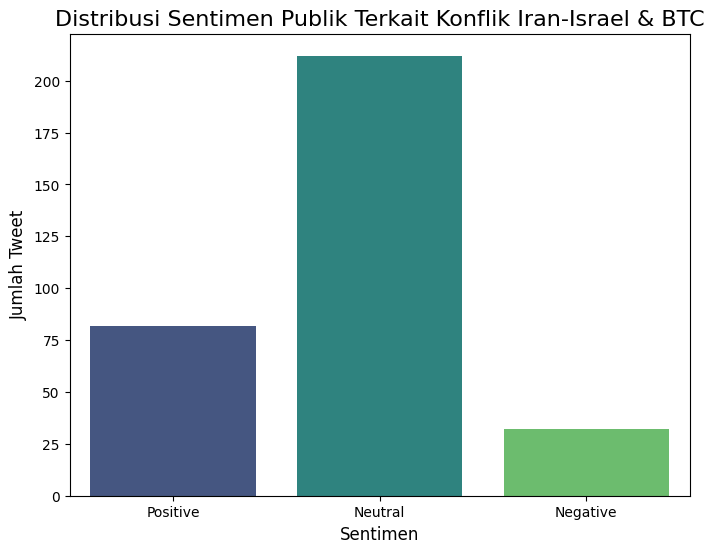


--- Tabel Perbandingan Metrik Evaluasi Lengkap ---
                     Accuracy  Precision  Recall  F1-Score
Model                                                     
Naive Bayes             0.671      0.782   0.671     0.560
Logistic Regression     0.695      0.793   0.695     0.609
Random Forest           0.744      0.792   0.744     0.696
--------------------------------------------------



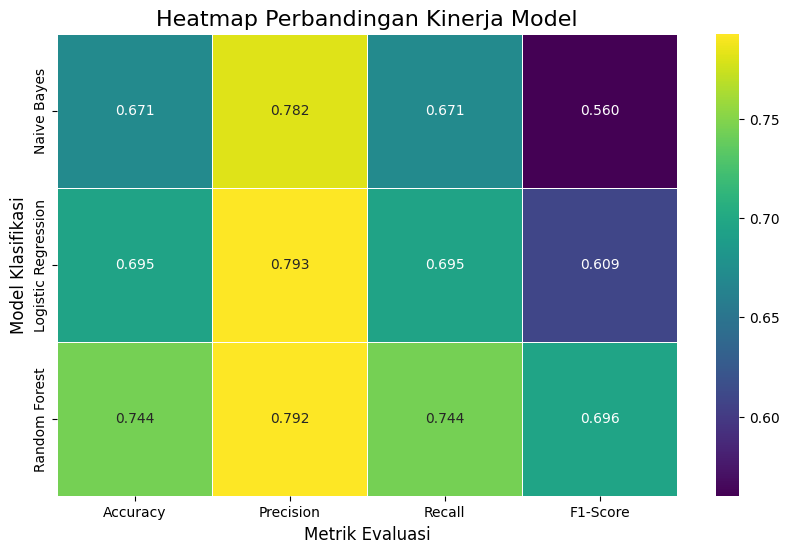

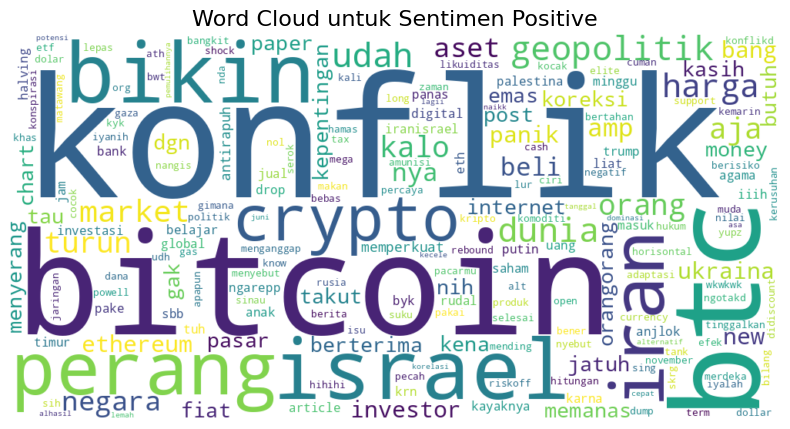

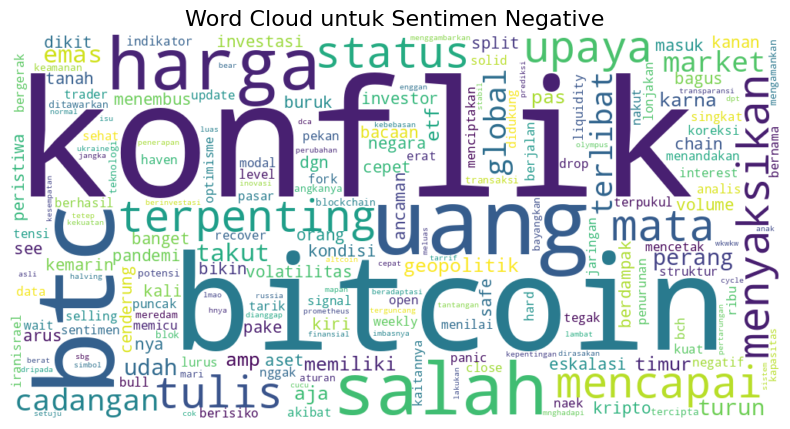

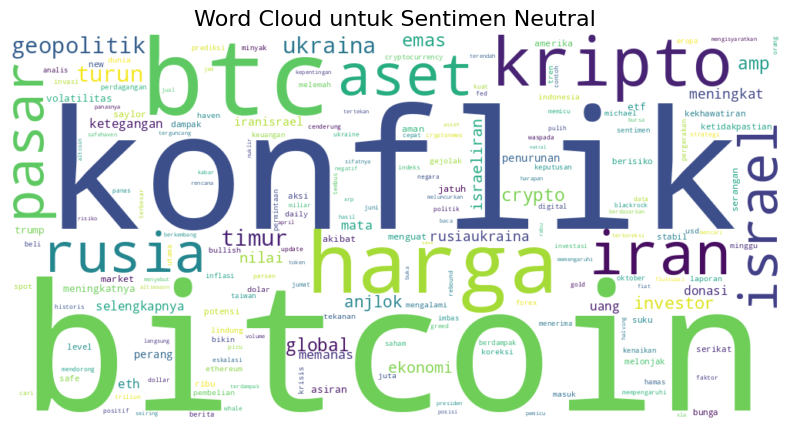


🎉 Analisis Selesai.


In [ ]:
# ==============================================================================
# BAGIAN 5: VISUALISASI HASIL & KESIMPULAN (DENGAN METRIK LENGKAP)
# ==============================================================================
if not df.empty and 'sentiment' in df.columns:
    print("\n📊 Memulai visualisasi hasil analisis...")

    # 1. Visualisasi Distribusi Sentimen (dari BERT)
    # Ditambahkan hue='x' dan legend=False untuk mengatasi FutureWarning
    plt.figure(figsize=(8, 6))
    sns.countplot(x='sentiment', data=df, order=['Positive', 'Neutral', 'Negative'], palette='viridis', hue='sentiment', legend=False)
    plt.title('Distribusi Sentimen Publik Terkait Konflik Iran-Israel & BTC', fontsize=16)
    plt.xlabel('Sentimen', fontsize=12)
    plt.ylabel('Jumlah Tweet', fontsize=12)
    plt.show()

    # Mengekstrak Metrik Lengkap dan Membuat Tabel Perbandingan
    # Membuat daftar untuk menyimpan hasil yang lebih detail
    detailed_results = []
    for name, res in results.items():
        # Mengambil nilai dari 'weighted avg' di classification report
        report_avg = res['Report']['weighted avg']
        detailed_results.append({
            'Model': name,
            'Accuracy': res['Accuracy'],
            'Precision': report_avg['precision'],
            'Recall': report_avg['recall'],
            'F1-Score': report_avg['f1-score']
        })

    # Membuat DataFrame dari daftar hasil yang detail
    results_df = pd.DataFrame(detailed_results)
    results_df.set_index('Model', inplace=True) # Menjadikan nama model sebagai index

    print("\n--- Tabel Perbandingan Metrik Evaluasi Lengkap ---")
    print(results_df.round(3))
    print("--------------------------------------------------\n")

    # Membuat Heatmap untuk Visualisasi Perbandingan Metrik
    plt.figure(figsize=(10, 6))
    sns.heatmap(results_df, annot=True, cmap='viridis', fmt=".3f", linewidths=.5)
    plt.title('Heatmap Perbandingan Kinerja Model', fontsize=16)
    plt.xlabel('Metrik Evaluasi', fontsize=12)
    plt.ylabel('Model Klasifikasi', fontsize=12)
    plt.show()


    # 3. Word Cloud per Sentimen
    for sentiment_label in ['Positive', 'Negative', 'Neutral']:
        text = " ".join(review for review in df[df["sentiment"] == sentiment_label].processed_text)
        if text.strip():
            wordcloud = WordCloud(width=1000, height=500, background_color="white", collocations=False).generate(text)
            plt.figure(figsize=(10, 5))
            plt.imshow(wordcloud, interpolation='bilinear')
            plt.axis("off")
            plt.title(f'Word Cloud untuk Sentimen {sentiment_label}', fontsize=16)
            plt.show()

print("\n🎉 Analisis Selesai.")